# Learning Bayesian Statistics with Pokemon GO

PyMCon 2020

Tushar Chandra (https://tusharc.dev)

# About Me

<br><br>

Senior data scientist at Nielsen Global Media in Chicago, IL.
    
I love cats, chai, and video games (currently playing the Mario 3D collection).

I blog about HCI research, social media, and data science at https://tusharc.dev. (These slides can be found there too!)



<img src="images/headshot.jpg">


# Talk Outline
In this talk, we'll be developing basic Bayesian models using PyMC3.

The models will be motivated by questions that come out of the mobile game Pokemon GO.

Sections include:
 * Background on Pokemon GO
 * Tools of the trade
 * Models ???

# &nbsp;

<img src="https://cdn.rawgit.com/pymc-devs/pymc3/master/docs/logos/svg/PyMC3_banner.svg" style="height:20rem; margin-left:auto; margin-right: auto;">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/23/Pok%C3%A9mon_GO_logo.svg/1280px-Pok%C3%A9mon_GO_logo.svg.png" style="height:20rem; margin-left:auto; margin-right: auto;">


# Pokemon GO Background

Pokemon GO is a popular mobile game, released in 2016. 

Players see a map of their area with Pokemon on it, and they can catch and collect these Pokemon.

**Why Pokemon GO?** It's one of my favorite games, and randomness and probability are at the heart of the game (often to a fault).



<img src="images/pogo_screenshot.png" style="height:60%; margin-left: auto;">

# Pokemon GO Background

**Pokemon** are virtual creatures that you can encounter and collect.

**Shiny Pokemon** are specially colored, rare, and therefore sought after by collectors.

There are lots of ways to get them, but they're always rare.

And players don't know exactly how rare!

<img src="images/shiny_hooh.png">

# Let's get started
Shiny Rayquaza was released into raids in August 2019.

Suppose my friend group did 44 raids and got 2 shinies. What do we think the shiny rate is?

<img src="images/shinyrayquazaraid.jpg">

## Describe the problem
I like to describe problems in terms of the *data that could have generated it.*

**Why?** Because it helps me to lay out my assumptions and understanding of the problem. 

Bayesian modeling isn't as hard as it sounds, but it's not a magic bullet, either. A lousy Bayesian model is just as bad as a lousy frequentist one.


## Data generation
Say there's some probability $p_{shiny}$ of seeing a shiny. Maybe it's 1 in 10, maybe it's 1 in 20, who knows.

(Are we sure that this probability exists? What if it changes over time? What if it's higher for some players?)

Given that probability, we saw 2 shinies in 44 attempts. If we assume all the attempts are independent, and that the probability was constant across attempts, that's a [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution).

## Sketch a model
We use `pm.Model` as a context manager for models.

Within models, we can recreate our data generating process, which was:
 * some probability $p_{shiny}$ of seeing a shiny
 * an observed 2 shinies in 44 attempts, which follows a binomial distribution
 
(This is pseudocode.)


&nbsp;

&nbsp;

&nbsp;

```python

def our_first_model():
    p_shiny = a prior (coming soon!)
    n_shinies = pm.Binomial(...)
```

&nbsp;

&nbsp;


## Fill in the gaps
Let's start with our Binomial. According to the [docs](https://docs.pymc.io/api/distributions/discrete.html#pymc3.distributions.discrete.Binomial) we have to pass:
 * a string name (`number_of_shinies`)
 * number of attempts (44)
 * probability (`p_shiny`)
 * optionally, number of successes (2)

What's that name? One of the quirks of PyMC3 (and other probabilistic programming libraries, like Pyro and NumPyro) is that you have to give your variables string names. That's what the string `"number_of_shinies"` is.


&nbsp;

&nbsp;

&nbsp;

```python
with pm.Model() as our_first_model:
    p_shiny = ...
    n_shinies = pm.Binomial(
        "number_of_shinies",
        44,
        p_shiny,
        observed=2,
    )
```

In [53]:
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns

pal = sns.color_palette("Set2")
sns.set()

## Choosing a prior
What about the `p_shiny` term? We need to fill it in with a **prior**.

In Bayesian inference, our *prior beliefs* are what we think might be plausible, before we have any data.

Since this is a prior for a probability, our only requirement is that the distribution be constrained to the interval 0 to 1.

In the case of shinies, we know they're rare (likely < 50%). Let's choose a prior distribution that puts most of its density in low probability regions.

**There is no *best* prior choice!** Here are two that look almost identical.

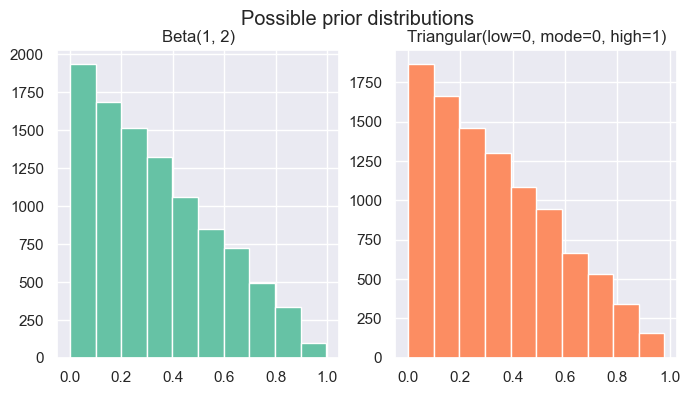

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(
    pm.Beta.dist(1, 2).random(size=(10000,)),
    color=pal[0],
)
ax[1].hist(
    pm.Triangular.dist(c=0).random(size=(10000,)),
    color=pal[1],
)
ax[0].set_title("Beta(1, 2)")
ax[1].set_title("Triangular(low=0, mode=0, high=1)")
_ = fig.suptitle("Possible prior distributions")

## Our first model
So what does the model look like? Let's fill in the last part.

... now what ...? 

In [60]:
with pm.Model() as our_first_model:
    p_shiny = pm.Beta("p_shiny", 1, 2)
    n_shinies = pm.Binomial(
        "number_of_shinies",
        44,
        p_shiny,
        observed=2,
    )


## Prior predictive checks
Remember that we designed our model to mimic the data generating process.

Given this, if we run the model several times (without any data), we should get *plausible* data.

These are called *prior predictive checks*. They basically ask: given *only* your priors, what data do you get?

(This was pretty confusing when I was learning!)


In [72]:
with our_first_model:
    prior = pm.sample_prior_predictive()
    print(f"Keys: {prior.keys()}")
    print(f"Shape: {prior['number_of_shinies'].shape}")
    
    
    
    
    
    
    

Keys: dict_keys(['p_shiny', 'p_shiny_logodds__', 'number_of_shinies'])
Shape: (500,)


## So, uh, what did we get?
The `prior` object is a dictionary with keys `p_shiny`, `p_shiny_logodds__`, and `number_of_shinies`.
 * `p_shiny` is an array of samples for what p_shiny could be
 * `p_shiny_logodds__` is the log-odds (loosely, how likely each was) for each of the values in `p_shiny`
 * `number_of_shinies` is an array of samples for what the number of shinies could be

Let's plot these!

Text(0.5, 1.0, 'Prior for # of shinies')

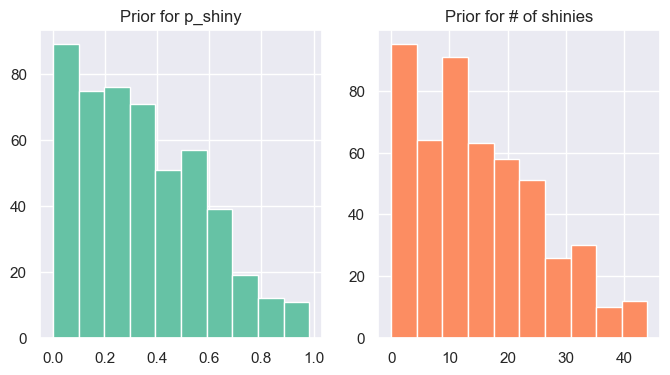

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(
    prior["p_shiny"], color=pal[0],
)
ax[1].hist(
    prior["number_of_shinies"],
    color=pal[1],
)
ax[0].set_title("Prior for p_shiny")
ax[1].set_title("Prior for # of shinies")

## How do we feel?
The prior predictive for p_shiny roughly matches the samples that we drew for `Beta(1, 2)` earlier. That's good!

The prior for the number of shinies does say that a small number of shinies is most likely, but it's (to me) overconfident in a large number.

But it doesn't exceed 44 (if it did, we'd have a bug already!).

And I don't *generally* suggest mucking around with priors early on. Just build something and iterate later!


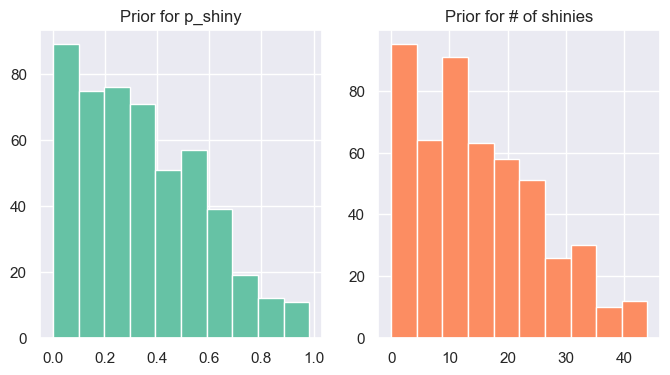

## Let's sample
It's time for us to use the [Magic Inference Button](https://twiecki.io/blog/2013/08/12/bayesian-glms-1/), as one of the PyMC devs calls it.

What's that mean? **Markov Chain Monte Carlo**, or the secret sauce behind almost all Bayesian models.

MCMC in a nutshell:
 * given your model (a process from which data is generated)
 * and some observations (examples of the generated data)
 * condition the model on the data, to understand how the data was most likely to be generated

Prior predictive checks = use the model to learn about the data.

MCMC = use the data to learn about the model.


In [76]:
with our_first_model:
    trace = pm.sample(draws=2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_shiny]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:03<00:00, 3469.77draws/s]


## Woah! What just happened?
It's MCMC!

**TODO**: more explanation of what's going on here.

## What happened?

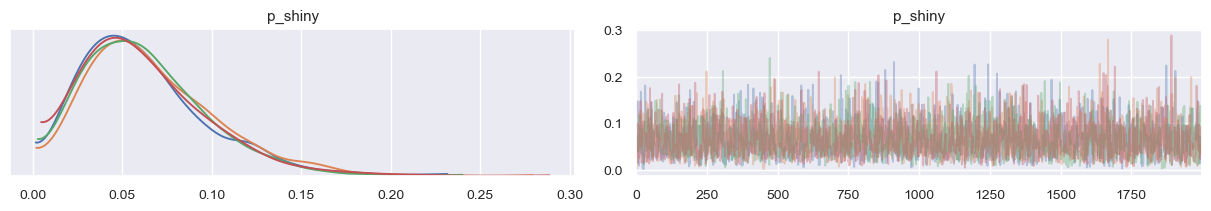

In [90]:
import arviz as az
import warnings
warnings.filterwarnings(action="ignore", category=UserWarning)

_ = az.plot_trace(trace)

In [81]:
import importlib
importlib.reload(az)

<module 'arviz' from '/Users/tushar/miniconda3/envs/pymcon/lib/python3.8/site-packages/arviz/__init__.py'>

Text(0.5, 0.98, 'Four possible prior distributions')

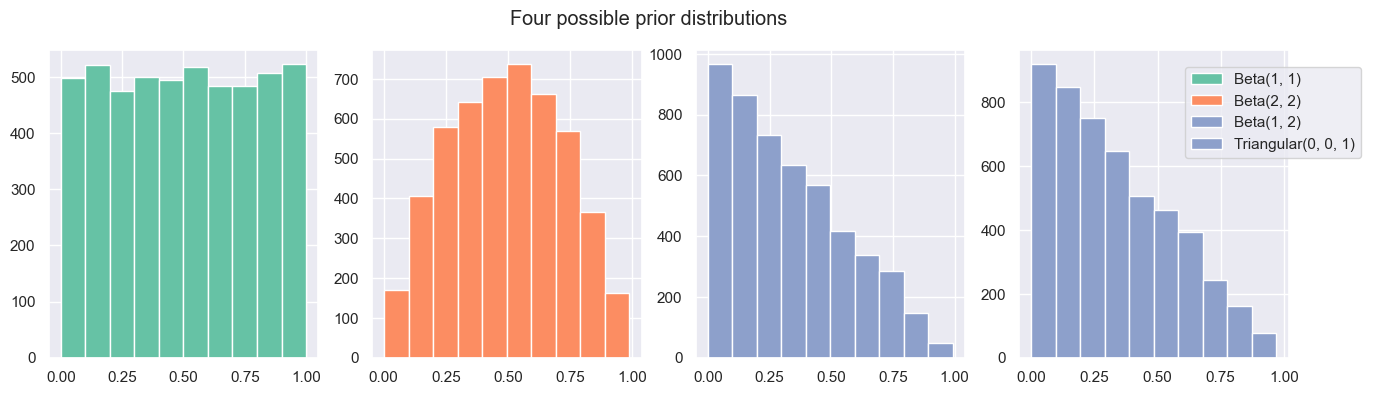

In [51]:
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns

pal = sns.color_palette("Set2")
sns.set()

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].hist(pm.Beta.dist(1, 1).random(size=(5000,)), label="Beta(1, 1)", color=pal[0])
ax[1].hist(pm.Beta.dist(2, 2).random(size=(5000,)), label="Beta(2, 2)", color=pal[1])
ax[2].hist(pm.Beta.dist(1, 2).random(size=(5000,)), label="Beta(1, 2)", color=pal[2])
# ax[3].hist(pm.Beta.dist(1, 6).random(size=(5000,)), label="Beta(1, 6)", color=pal[4])
ax[3].hist(pm.Triangular.dist(c=0).random(size=(5000,)), label="Triangular(0, 0, 1)", color=pal[2])
fig.legend(loc=(0.85, 0.6))
fig.suptitle("Four possible prior distributions")

In [4]:
%matplotlib inline

import pymc3 as pm

In [ ]:
with pm.Model() as model:
    

## Did our prior choice matter?
Let's re-run the model with different priors and see what we get.